In [2]:
import gym
import logging
import numpy as np
import dill as pickle
import os

from threading import Thread, Lock
from time import sleep
from client import CarDirection, Client
from env import JunctionEnvironment
from matplotlib import pyplot as plt
from alg_astar import *

%load_ext autoreload
%autoreload 2

In [3]:
logger = logging.getLogger(None)
logger.setLevel(logging.WARNING)

In [4]:
team_name = "ipa"
team_key = "admin"
N_GAMES = 1
CACHE_DIR = "./cache"
DATASET_DIR = os.path.join(CACHE_DIR, "dataset")
IMIT_LEARNING_DATASET_DIR = os.path.join(DATASET_DIR, "imitation_learning")

if not os.path.isdir(IMIT_LEARNING_DATASET_DIR):
    os.makedirs(IMIT_LEARNING_DATASET_DIR)

In [5]:
class Runner(Thread):
    def __init__(self, car_id, game_id, env, lock):
        super().__init__()
        self.car_id = car_id
        self.game_id = game_id
        self.env = env
        self.lock = lock
        
        self.prev_obs = None
        
        self.obss = []
        self.scores = []
        self.actions = []
        
        self.current_target = None


    def megaalg(self, obs):
        car_x, car_y = np.where(obs[:,:,4])[0][0], np.where(obs[:,:,4])[1][0]
        customer_positions = []
        customer_dists = []
        paths_to_clients = []
        maze = 1-obs[:,:,0]
        statuses = []

        if obs[:,:,3].sum() > 0:
            # go to destination
            if self.current_target is None:
                self.current_target = np.where(obs[:,:,3])[0][0], np.where(obs[:,:,3])[1][0]
            x, y = self.current_target
            path, _ = search(maze, 1, (car_x, car_y), (x ,y))
            if not path:
                self.current_target = None
                return 4
            target_cell = path[0]
            if len(path)==1:
                self.current_target = None
        else:
            # look for customer

            if obs[:,:,1].sum() == 0:
                return 4
            coords = np.where(obs[:,:,1])

            if self.current_target is None:
                for i in range(len(coords[0])):
                    x, y = coords[0][i], coords[1][i]
                    customer_positions.append((x,y))
                    dist = np.abs(car_x - x) + np.abs(car_y - y)
                    customer_dists.append(dist)
                    path, status = search(maze, 1, (car_x, car_y), (x ,y))
                    paths_to_clients.append(path)
                    statuses.append(status)

                completed_paths = [p for p,s in zip(paths_to_clients, statuses) if s==0]
                if len(completed_paths)>0:
                    min_path = min(completed_paths, key = lambda p: len(p))
                else:
                    min_ind = np.argmin(np.array(customer_dists))
                    min_path = paths_to_clients[min_ind]

                self.current_target = min_path[-1]

                #current_target, path = min(zip(customer_dists, paths_to_clients), key = lambda p: len(p[1]))
                target_cell = min_path[0]
            else:
                x, y = self.current_target
                print(car_x, car_y)
                path, _ = search(maze, 1, (car_x, car_y), (x ,y))
                if not path:
                    self.current_target = None
                    return 4
                target_cell = path[0]
                if len(path)==1:
                    self.current_target = None
            #current_path = current_path[1:] if len(current_path) > 1 else None

            #target_cell = path[0] if path is not None else None

        print(target_cell, car_x, car_y)
        if target_cell is None:
            return 4
        if target_cell[0] == car_x and target_cell[1] == car_y - 1:
            #return 3
            return 3
        if target_cell[0] == car_x and target_cell[1] == car_y + 1:
            #return 1
            return 1
        if target_cell[0] == car_x - 1 and target_cell[1] == car_y:
            #return 2
            return 2
        if target_cell[0] == car_x + 1 and target_cell[1] == car_y:
            #return 0
            return 0
        return 4

        
    def run(self):
        # Need to do some initial action to fetch observations
        obs, score, done, _ = self.env.step(1, self.car_id)
        self.prev_obs = obs
        
        while True:
            try:
                new_action = self.megaalg(self.prev_obs)
                self.lock.acquire()
                print(new_action)
                obs, score, done, _ = self.env.step(new_action, self.car_id)
                # print(score, done)
            except Exception as ex:
                # print(f"{self.car_id}: {ex}")
                raise ex
            finally:
                try:
                    self.lock.release()
                except:
                    pass
            if done:
                break

            action = new_action

            self.obss.append(self.prev_obs)
            self.scores.append(score)
            self.actions.append(action)

            self.prev_obs = obs                
           # sleep(0.5)
           
        
        self.obss = np.array(self.obss)
        self.scores = np.array(self.scores)
        self.actions = np.array(self.actions)
        
        with open(os.path.join(IMIT_LEARNING_DATASET_DIR, f"game_{self.game_id}_car_{self.car_id}_obs.pkl"), "wb") as f:
            pickle.dump(self.obss, f)
        with open(os.path.join(IMIT_LEARNING_DATASET_DIR, f"game_{self.game_id}_car_{self.car_id}_scores.pkl"), "wb") as f:
            pickle.dump(self.scores, f)
        with open(os.path.join(IMIT_LEARNING_DATASET_DIR, f"game_{self.game_id}_car_{self.car_id}_actions.pkl"), "wb") as f:
            pickle.dump(self.actions, f)
        print(f"{self.car_id} finished")

In [13]:
def center_pad_observations(obs, receptor_size=100):
    res = []
    for i in range(obs.shape[0]):
        npad_ = (receptor_size-obs.shape[1])//2 # make sure the receptive field is always 200
        npads = ((0, 0), (npad_, npad_), (npad_, npad_), (0, 0))
        r = np.pad(obs, pad_width=npads, mode='constant', constant_values=0)
        res.append(r)
    return np.array(res, dtype=np.int8)

In [7]:
game_ids = []

if __name__ == "__main__":
    print("In main thread")
    client = Client(team_name=team_name, team_key=team_key)
    env = JunctionEnvironment(client)

    lock = Lock()

    for i in range(N_GAMES):
        print("Running game", i)
        game_id = np.random.randint(0, 100000)
        _ = env.reset()

        processes = []
        for car_id in env.car_ids:
            process = Runner(car_id, game_id, env, lock)
            processes.append(process)
            

        for process in processes:
            process.start()

        for process in processes:
            process.join()
        print(f"Game {i} finished")
        game_ids.append(game_id)

In main thread
Running game 0
(6, 20) 5 20
0
(1, 17) 0 17
(8, 20) 8 21
0
6 20
(7, 20) 6 20
3
1 17
(1, 18) 1 17
0
8 20
(8, 19) 8 20
1
7 20
(7, 19) 7 20
3
1 18
(2, 18) 1 18
3
8 19
(8, 18) 8 19
0
7 19
(8, 19) 7 19
3
2 18
(2, 19) 2 18
0(8, 19) 8 18

1
8 19
(8, 18) 8 19
2 19
(3, 19) 2 19
1
(8, 20) 8 19
3
0
13 19

(8, 20) 8 19
1
(8, 21) 8 20
1
(9, 21) 8 21
0
(9, 22) 9 21
1
(9, 23) 9 22
1
(10, 23) 9 23
0
giving up on pathfinding too many iterations
(8, 18) 8 19
3(11, 23)
 10 23
giving up on pathfinding too many iterations
(3, 20) 3 19
0
8 18
(8, 17) 8 18
(12, 23) 11 23
1
3
3 20
(3, 21) 3 20
0
8 17
(8, 16) 8 17
1
(13, 23) 12 23
3
3 21
(3, 22) 3 21
80
 16
(8, 15) 8 16
1
(14, 23) 13 23
3
3 22
(3, 23) 3 22
0
8 15
(8, 14) 8 15
(15, 23)1 14 23

3
3 23
(2, 23) 3 23
(8, 13) 8 14
0
(16, 23) 15 2
23
3
(3, 23) 2 23
(8, 12) 8 13
0
(17, 23) 16 23
0
(3, 22) 3 23
3
(8, 11) 8 12
0
3
(18, 23) 17 23
3
(3, 21) 3 22
(8, 10) 8 11
0
3
(19, 23) 18 23
(4, 21) 3 21
3
0
(8, 9) 8 10
0
19 23
(20, 23) 19 23
3
(4, 20) 4 2

0
(9, 14) 8 14
0
(11, 23) 10 23
(15, 11) 15 12
0
0
9 14
(10, 14) 9 14
3
(12, 23) 11 23
0
(16, 11) 15 11
0
10 14
(11, 14) 10 14
0
(13, 23) 12 23
(16, 10) 16 11
0
0
11 14
(12, 14) 11 14
(14, 23) 13 23
3
(16, 9) 16 10
0
0
12 14
(13, 14) 12 14
3
(15, 23) 14 23
(17, 9) 16 9
0
0
13 14
(13, 13) 13 14
0(16, 23)
 15 23
(18, 9) 17 9
3
0
13 13
(14, 13) 13 13
0
(17, 23) 16 23
0
(18, 8) 18 9
(14, 14)0 14 13

3(18, 23) 17
 23
1(18, 7) 
18 8
(13, 14) 14 14
0
(18, 24) 18 23
3
(18, 6) 18 7
2
(13, 15) 13 14
1
(18, 25) 18 24
3
(18, 7) 18 6
1
(12, 15) 13 15
1
1
(18, 26) 18 25
2
(19, 7) 18 7
1
(11, 15) 12 15
0
(18, 25) 18 26
(20, 7) 19 7
2
3
(11, 16) 11 15
0
(18, 24) 18 25
(20, 6) 20 7
1
(10, 16) 11 16
3
3
(18, 23) 18 24
(21, 6) 20 6
2
(10, 17) 10 16
3
0
(19, 23) 18 23
(20, 6) 21 6
1
0(9, 17) 10 17

2
(20, 23) 19 23
(21, 6) 20 6
2
(9, 18) 9 17
0
(20, 22) 20 23
0
1
(20, 6) 21 6
(8, 18) 9 18
3
2
(20, 21) 20 22
(21, 6) 20 6
2
3
(8, 19) 8 18
(20, 20) 20 21
0
(21, 5) 21 6
1
(8, 20) 8 19
3
3(20, 19) 20 20

(21, 

In [ ]:
import glob
import pickle

# get all car data and append it
obs = np.empty((0,100,100,8), dtype=np.int8) # specify the size of the channels
actions = np.empty((0))
scores = np.empty((0))

# Load and concat
for data_type in ["obs", "actions", "scores"]:
    for game_id in game_ids:
        file_names = glob.glob(os.path.join(IMIT_LEARNING_DATASET_DIR, 'game_{0}_car_*_{1}.pkl'.format(game_id, data_type)))
        for f_name in file_names:
            with open(f_name, 'rb') as f:
                data = pickle.load(f)
            if data_type == "obs":
                data = center_pad_observations(data, receptor_size=100)
                obs = np.append(obs, data, axis=0)
            if data_type == "actions":
                actions = np.append(actions, data, axis=0)
            if data_type == "scores":
                scores = np.append(scores, data, axis=0)
    print("finished appending ", data_type)
     
# save the concated all data              
with open(os.path.join(IMIT_LEARNING_DATASET_DIR, 'obs_all.pkl'), 'wb') as f:
    print("obs shape: ", obs.shape)
    pickle.dump(obs, f)
    
with open(os.path.join(IMIT_LEARNING_DATASET_DIR, 'actions_all.pkl'), 'wb') as f:
    print("actions shape: ", actions.shape)
    pickle.dump(actions, f)
    
with open(os.path.join(IMIT_LEARNING_DATASET_DIR, 'scores_all.pkl'), 'wb') as f:
    print("scores shape: ", scores.shape)
    pickle.dump(scores, f)

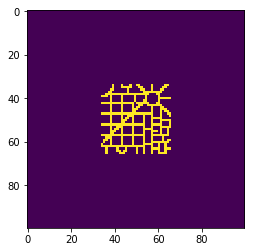

In [35]:
plt.imshow(obs[0,:,:,0])

In [36]:
game_id

46749

In [26]:
np.max(scores)

65774.0

In [27]:
len(scores)

950